In [2]:
import utility as ut
import pipelines_utils as pput
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [3]:
dataset = ut.ImageDataset()

In [5]:
dataset.parse_labels_from_file_name()

Loaded 2688 images with labels.
Found 8 unique labels.['coast' 'forest' 'highway' 'insidecity' 'mountain' 'opencountry' 'street'
 'tallbuilding']


In [6]:
train_data,val_data,test_data = pput.split_dataset(dataset)

In [7]:
test_img, test_labels = test_data[0], test_data[1]

In [8]:
dict_image = {}
for cat in dataset.unique_labels:
    dict_image[cat] = []
    for j in range (len(test_labels)):
            if len(dict_image[cat]) > 2:
              break
            if test_labels[j] == cat  :
              dict_image[cat].append(test_img[j])

print(dict_image)


{'coast': ['/content/drive/MyDrive/image_dataset/coast_n291032.jpg', '/content/drive/MyDrive/image_dataset/coast_natu826.jpg', '/content/drive/MyDrive/image_dataset/coast_sun4.jpg'], 'forest': ['/content/drive/MyDrive/image_dataset/forest_nat451.jpg', '/content/drive/MyDrive/image_dataset/forest_nat1095.jpg', '/content/drive/MyDrive/image_dataset/forest_natu161.jpg'], 'highway': ['/content/drive/MyDrive/image_dataset/highway_bost165.jpg', '/content/drive/MyDrive/image_dataset/highway_gre153.jpg', '/content/drive/MyDrive/image_dataset/highway_nat518.jpg'], 'insidecity': ['/content/drive/MyDrive/image_dataset/insidecity_gre511.jpg', '/content/drive/MyDrive/image_dataset/insidecity_art1117.jpg', '/content/drive/MyDrive/image_dataset/insidecity_city84.jpg'], 'mountain': ['/content/drive/MyDrive/image_dataset/mountain_sharp12.jpg', '/content/drive/MyDrive/image_dataset/mountain_sharp44.jpg', '/content/drive/MyDrive/image_dataset/mountain_art1132.jpg'], 'opencountry': ['/content/drive/MyDriv

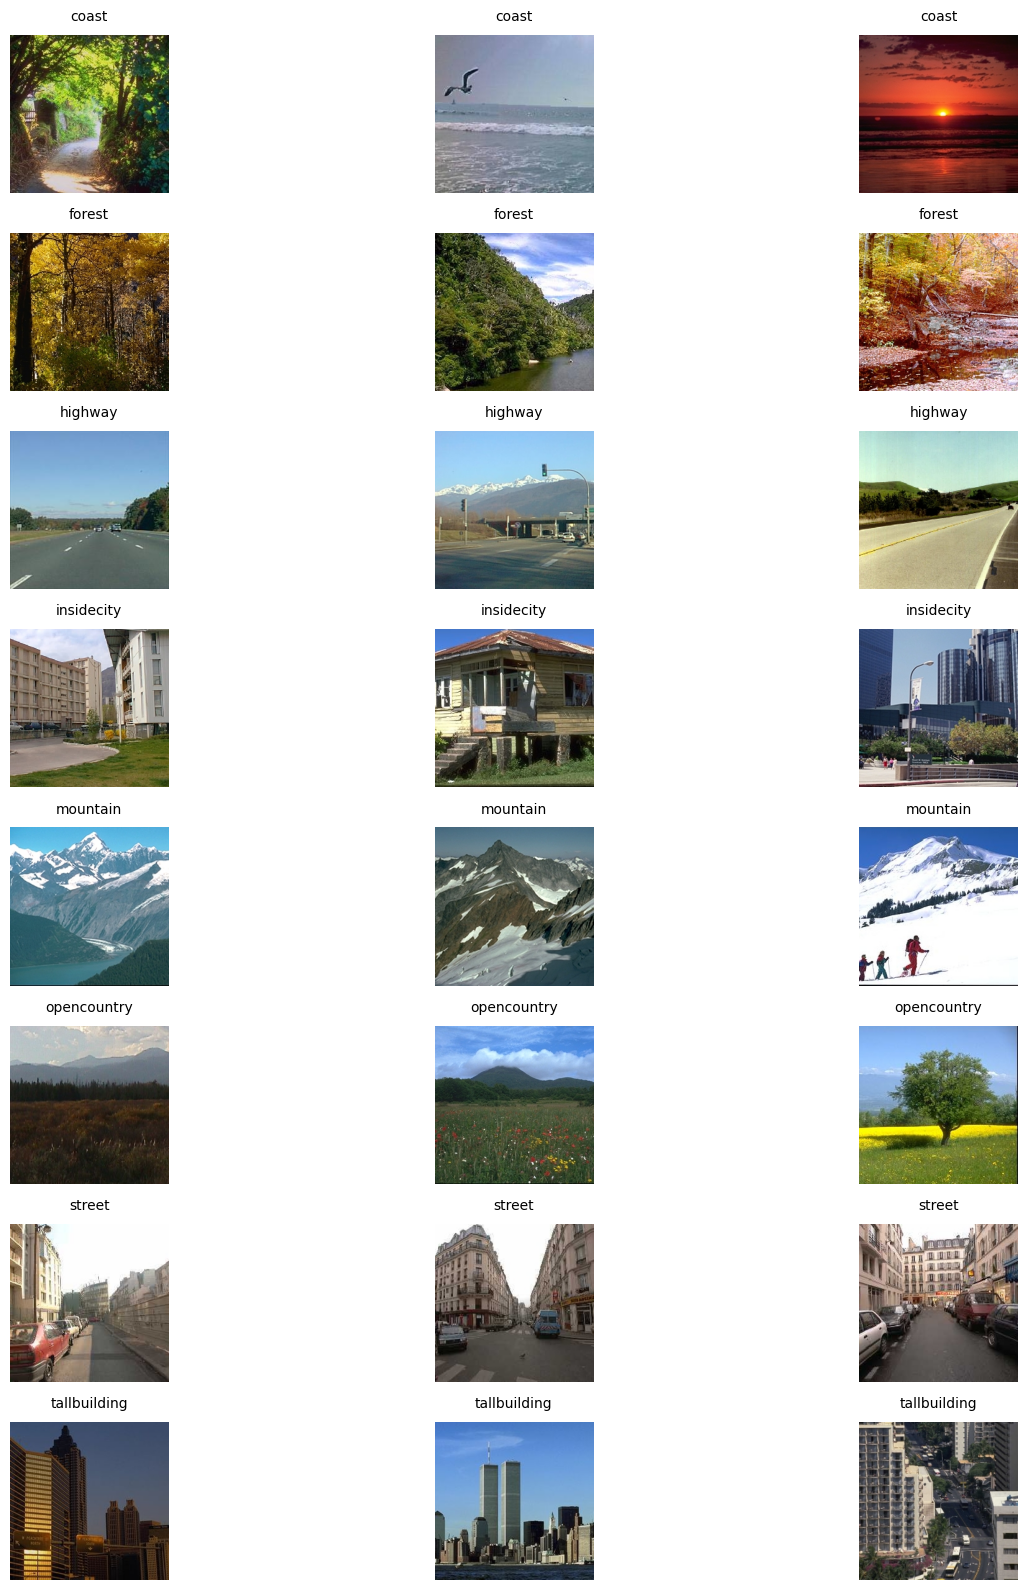

In [ ]:
# Plot settings
categories = list(dict_image.keys())
n_categories = len(categories)
images_per_category = 3  # Limit to 3 images per category
fig, axes = plt.subplots(n_categories, images_per_category, figsize=(15, 2 * n_categories))

# Iterate over categories and images
for row, category in enumerate(categories):
    for col in range(images_per_category):
        try:
            # Load the image
            img = Image.open(dict_image[category][col])
            ax = axes[row, col] if len(categories) > 1 else axes[col]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(category, fontsize=10, pad=10)  # Set category of image
        except IndexError:
            # Skip if fewer images exist
            axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [59]:
import torch
import torch.nn as nn

# Residual Block definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


class MYResNet(nn.Module):
    def __init__(self, block, layers, num_classes=8):
        super(MYResNet, self).__init__()
        self.in_channels = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2, padding=2)
        self.dropout = nn.Dropout(p=0.5)

        # Reduced blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 256),  # Reduce intermediate FC layer size
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the model with 3 blocks
def ResNet3Blocks():
    return MYResNet(ResidualBlock, [2, 2, 2])  # Three blocks

# Instantiate the model
model = ResNet3Blocks()

# Print model summary (optional)
print(model)

import torch.optim as optim
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

MYResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=4, stride=2, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [37]:
from torch.utils.data import TensorDataset,DataLoader
def create_data_loader(data_set,batch_size=32, augmantation = False):

  image_to_tensor = dataset.load_image_as_tensor(data_set[0],augmantation)
  # Create a mapping from string labels to numerical indices

  label_to_index = {label: index for index, label in enumerate(dataset.unique_labels)}

  # Convert string labels in train_data[1] to numerical indices
  numerical_labels = torch.tensor([label_to_index[label] for label in data_set[1]],dtype=torch.long)
  tensor_dataset = TensorDataset(image_to_tensor, torch.tensor(numerical_labels))

  data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

  return data_loader


In [60]:
test_loader = create_data_loader(test_data)
val_loader = create_data_loader(val_data,batch_size=32,augmantation=True)
train_loader = create_data_loader(train_data,batch_size=32,augmantation=True)

<ipython-input-37-fea259a07b39>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_dataset = TensorDataset(image_to_tensor, torch.tensor(numerical_labels))


In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
import torch

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10, device="cpu"):
    """
    Trains a PyTorch model.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        loss_fn: The loss function to use.
        optimizer: The optimizer to use.
        num_epochs: The number of epochs to train for.
        device: The device to train on ("cpu" or "cuda").

    Returns:
        A tuple containing the trained model and the training history.
    """
    model.to(device)
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_history.append(train_loss)

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        predicted_lab = []
        with torch.no_grad():  # No need to track gradients during validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                val_loss += loss.item() * images.size(0)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted_lab.append(predicted)

        val_loss /= len(val_loader.dataset)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val_Accuracy: {accuracy:.2f}%")
        val_history.append(val_loss)
        scheduler.step(val_loss)
    return model, train_history, val_history

In [61]:
model_t, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, num_epochs=50, device="cuda")

Epoch [1/50], Train Loss: 1.7492, Val Loss: 1.8475, Val_Accuracy: 40.33%
Epoch [2/50], Train Loss: 1.3735, Val Loss: 1.5542, Val_Accuracy: 51.12%
Epoch [3/50], Train Loss: 1.1570, Val Loss: 1.2308, Val_Accuracy: 66.36%
Epoch [4/50], Train Loss: 1.0641, Val Loss: 1.4438, Val_Accuracy: 62.83%
Epoch [5/50], Train Loss: 0.9967, Val Loss: 1.0768, Val_Accuracy: 71.93%
Epoch [6/50], Train Loss: 0.9671, Val Loss: 1.1902, Val_Accuracy: 69.70%
Epoch [7/50], Train Loss: 0.9513, Val Loss: 1.0583, Val_Accuracy: 78.25%
Epoch [8/50], Train Loss: 0.8678, Val Loss: 1.1052, Val_Accuracy: 72.12%
Epoch [9/50], Train Loss: 0.8575, Val Loss: 1.0657, Val_Accuracy: 76.21%
Epoch [10/50], Train Loss: 0.8559, Val Loss: 1.0486, Val_Accuracy: 76.77%
Epoch [11/50], Train Loss: 0.8134, Val Loss: 0.9928, Val_Accuracy: 78.44%
Epoch [12/50], Train Loss: 0.8045, Val Loss: 1.1737, Val_Accuracy: 68.40%
Epoch [13/50], Train Loss: 0.7728, Val Loss: 1.0463, Val_Accuracy: 76.77%
Epoch [14/50], Train Loss: 0.7460, Val Loss: 0.

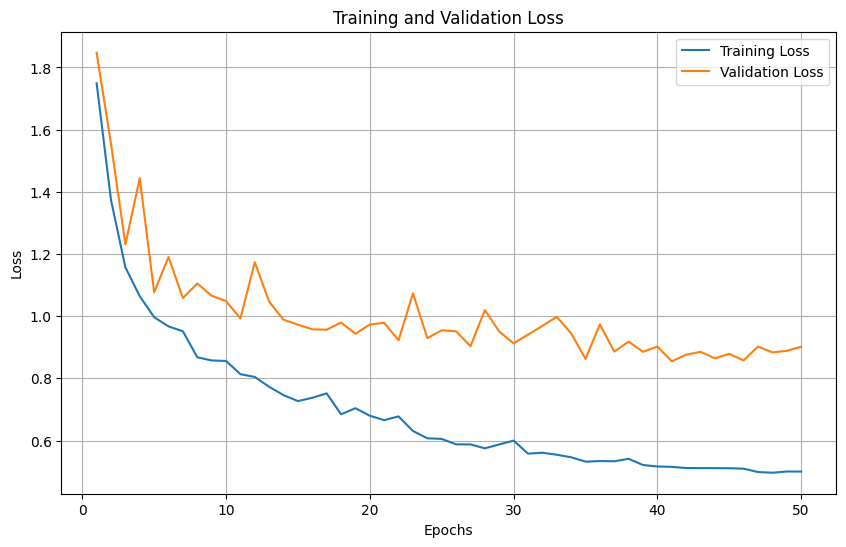

In [62]:
import matplotlib.pyplot as plt

# Assuming train_history and val_history are lists of loss values
epochs = range(1, len(train_history) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_history, label='Training Loss')
plt.plot(epochs, val_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

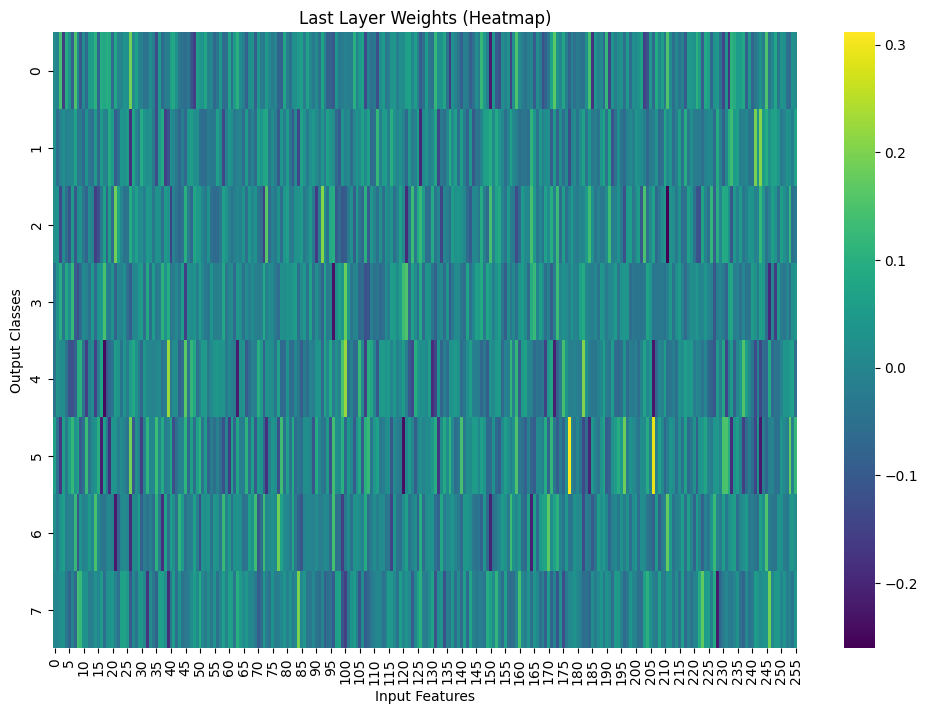

Mean: -0.0012675387552008033
Std Dev: 0.06549552828073502
Max Weight: 0.3115604519844055
Min Weight: -0.26068127155303955


In [63]:
import seaborn as sns
import torch

# Access the weights of the last fully connected layer
last_layer_weights = model_t.fc[2].weight.data.cpu()  # Assuming model.fc[-1] is the last Linear layer

# Convert weights to a 2D array for heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(last_layer_weights, cmap="viridis")
plt.title("Last Layer Weights (Heatmap)")
plt.xlabel("Input Features")
plt.ylabel("Output Classes")
plt.show()

# Inspect weight statistics
print(f"Mean: {last_layer_weights.mean().item()}")
print(f"Std Dev: {last_layer_weights.std().item()}")
print(f"Max Weight: {last_layer_weights.max().item()}")
print(f"Min Weight: {last_layer_weights.min().item()}")


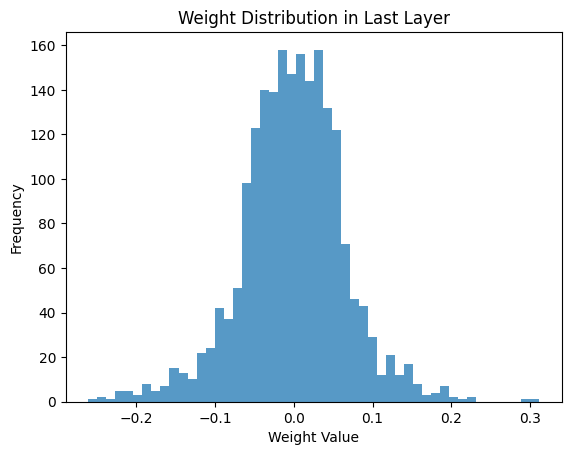

In [64]:
import matplotlib.pyplot as plt

weights = model_t.fc[2].weight.data.cpu().numpy().flatten()
plt.hist(weights, bins=50, alpha=0.75)
plt.title("Weight Distribution in Last Layer")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()

In [50]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def test_model1(model, test_loader, loss_fn, device="cpu", num_classes=8):
    """
    Tests a PyTorch model and computes metrics.

    Args:
        model: The PyTorch model to test.
        test_loader: DataLoader for the test data.
        loss_fn: The loss function to use.
        device: The device to test on ("cpu" or "cuda").
        num_classes: Number of classes in the dataset.

    Returns:
        A dictionary containing the test loss, accuracy, precision, recall, and F1 score.
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []  # For ROC and PR curves

    with torch.no_grad():  # No need to track gradients during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * images.size(0)

            # Predictions and probabilities
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")

    # ROC Curve and AUC (One-vs-Rest for Multiclass)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(
            np.array(all_labels) == i, np.array(all_probs)[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    pr_auc = {}
    for i in range(num_classes):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(
            np.array(all_labels) == i, np.array(all_probs)[:, i]
        )
        pr_auc[i] = auc(recall_dict[i], precision_dict[i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
        )
    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(
            recall_dict[i],
            precision_dict[i],
            label=f"Class {i} (AUC = {pr_auc[i]:.2f})"
        )
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

    return {
        "test_loss": test_loss,
        "accuracy": accuracy,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1_score": f1 * 100,
    }


Test Loss: 0.8877, Accuracy: 83.46%
Precision: 84.44%
Recall: 83.46%
F1 Score: 83.10%


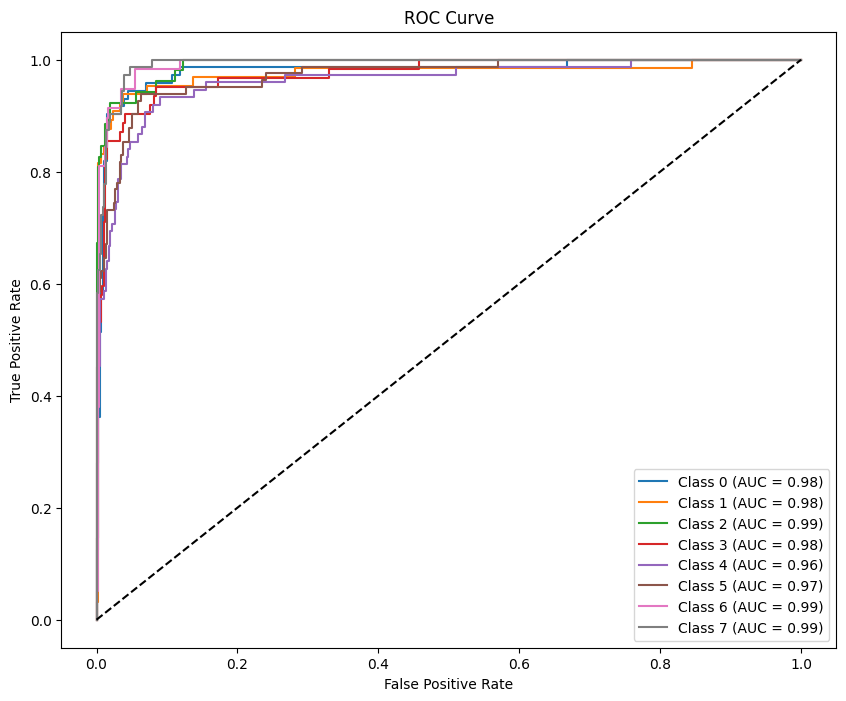

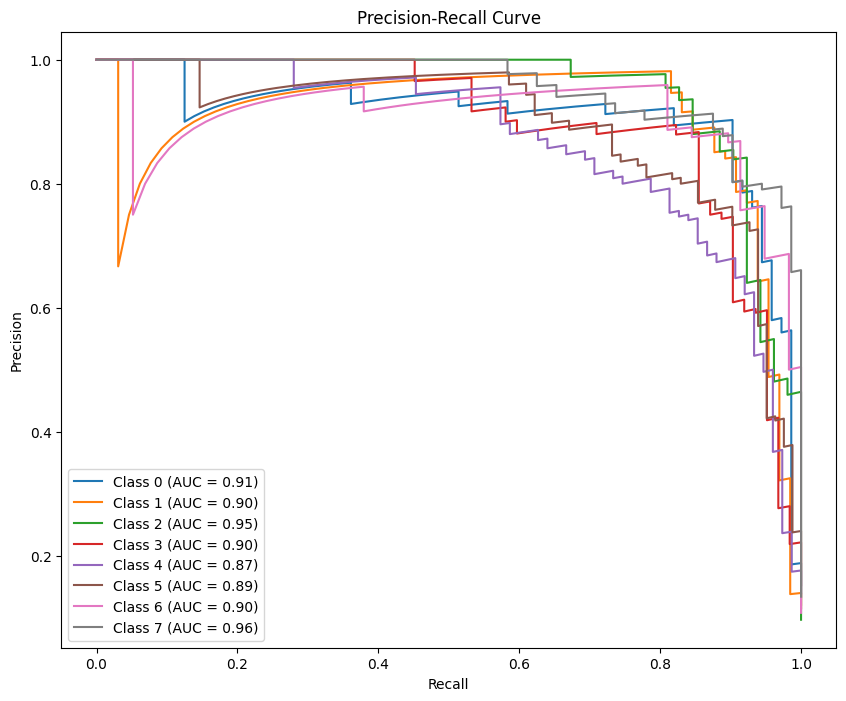

In [66]:
dict_test = test_model1(model_t, test_loader, loss, device="cuda")